# Back to the Future : Time Travelling through Wikispeedia

## Part 0 : Preprocessing of data

## Part 1 : Defining the best moment to play Wikispeedia

## Part 2 : Wikipedia evolution between 2007 and 2024

Firstly we investigate how did wikipedia evolve between 2007 and 2024. In this part we only compare the two structures for the 4600 articles that were selected in the 2007 Wikispeedia dataset. 

### 2.1) Loading the data

In [3]:
from src.scripts.loading_data import *

# importing articles names and links
articles2007, links2007 = loading_articles_links('2007')
articles2024, links2024 = loading_articles_links('2024')

# checking the sizes 
print('2007 :',len(articles2007)) 
print('2024 :',len(articles2024))

2007 : 4604
2024 : 4604


As mentionned above in part 0, some articles have been deleted between 2007 and 2024. So the list of articles of 2024 does not contain them and there are no links redirecting to them in the links2024 file. However we retrieved the articles whose names have been modified and kept the name for 2007 to refer to them in the 2024 list. 

In [4]:
selected_articles = articles_in_common(links2007, links2024)

### 2.2) Comparing the Hyperlinks Structure 

As a first analysis to justify our project we compare the two wikipedia version structures. 

T test p value : [6.91824887e-191]


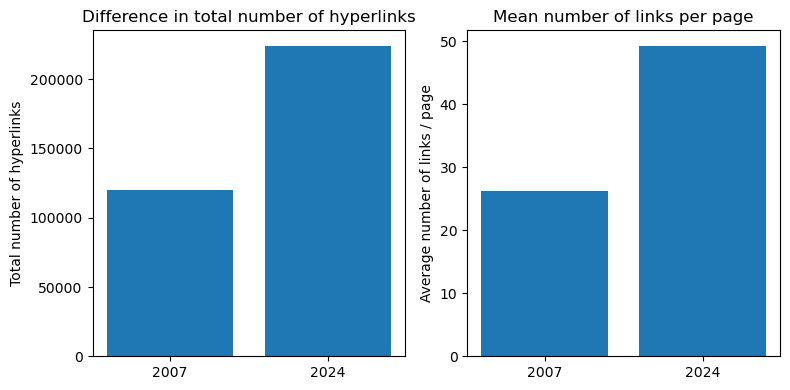

In [5]:
from src.scripts.plotting import *

plot_average_links_per_page(links2007, links2024)

### 2.3) Shortest Paths comparison

As a metric to how connected the two wikipedia are, we also look into the shortest path amtrix for the both of them. They are computed using the Floyd Warshall algorithms. We verified that the function used, from the networkx package, produced the exact same matrix for the 2007 data in the exploratory notebook. 

In [6]:
### creating Graphs 
G_2007 = creating_graph(links2007, articles2007)
G_2024 = creating_graph(links2024, articles2007)
# here we use the list of articles from 2007 as it has all the nodes
# whereas some are missing in the 2024 list as stated earlier 
# it is important to create all the nodes even if we don't have any link 
# that connects them to the other, in order to generate the difference map later
# so that the two spm have the same dimensions

### computing shortest path matrices (spm)
# this step takes approx 15 min
spm_2007 = computing_shortest_path_matrix(G_2007, articles2007)
spm_2024 = computing_shortest_path_matrix(G_2024, articles2007)

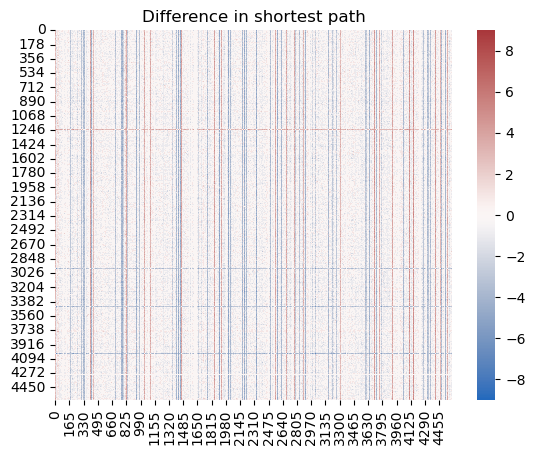

In [7]:
plotting_difference_heatmap(spm_2007,spm_2024)

## Part 3 : Performance of the players depending on the year

## Part 4 : LLM performance on different versions